# Preliminary analyses

This notebook performs an introductory exploration on the Google Cluster Dataset 2011, with the aim of uncovering information useful for profiling workloads.


## Imports

In [1]:
import pandas as pd

import dask.dataframe as dd
from dask.delayed import delayed

import numpy as np
import random
from scipy.stats import norm

import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler

from gcd_dask_mgmt import extract_delayed_dask_dataframe
from plot_functions import extract_jobs_comparison_plot

## Data load

In order to use the **google cluster data**, you have to:
1. first, install `gsutil` https://cloud.google.com/storage/docs/gsutil_install
2. then download the google cluster data, with the command `gsutil cp -R gs://clusterdata-2011-2/ <destination-directory>`

The dataset compressed size is approximately 41GB. 

Source: https://github.com/google/cluster-data/blob/master/ClusterData2011_2.md

In [2]:
# Change this with your destination directory
DESTINATION_DIRECTORY = "/data/cloud_data/Google-clusterdata-2011-2/"

In [3]:
# Uncomment and execute the following line if you need to download the dataset
# os.system("gsutil cp -R gs://clusterdata-2011-2/ {dest_dir}".format(dest_dir = DESTINATION_DIRECTORY))

In [4]:
data_path = os.path.join(DESTINATION_DIRECTORY, 'clusterdata-2011-2')
schema_path = os.path.join(data_path, 'schema.csv')

Let's load the schema, which is the table that contains the features for the various collections in the trace.

In [5]:
df_schema = pd.read_csv(schema_path)

## Extract job events infos

Here, we extract the collection *job_events*. To do so, we leverage the `extract_delayed_dask_dataframe` functions, which uses the module `dask`, to better handle large datasets that would not easily fit in memory. 

`extract_delayed_dask_dataframe` is an import from the functions' collector `gcd_dask_mgmt`.

In [6]:
readings_job_events_df = extract_delayed_dask_dataframe(data_path, df_schema, gcd_collection_name="job_events", 
                                                        interval_start=0, interval_end=500)

Find and print the top 20 users that create more jobs with various *logical job names*, i.e., applications.

In [7]:
users_stats = readings_job_events_df.groupby("user")["logical job name"].nunique().compute()
users_stats.sort_values(ascending=False).head(20)

user
QhKaMUnHYqtG1RJkmo+zqhY1dChfuOZ6oy8jYGDlsic=    13569
ycbMkTOh7F0buLKJlg4BU3OcBWrvF/JTZkXp9iv5zDg=     1952
njTE8BZMxQTFTmz+xeDNc6MGCjP2WhS6B4xK9+rTh8E=     1614
TpvNZQVOGF/Vr5q+Ka/froHMRlTulp4VfsBSHqvMnws=     1559
mbrS6V2tRbksMPO0y8EI9B9XT2ASaPRTNndslCGN/2A=     1450
5ANFyIGysAA6XzeFuFUqyXdJfrrczugfoYfXCP0FNk8=     1222
CCbg3K/uVFiG0k1eTEPIq8/Hgygvsn7T9Mk6/6PbmJ0=     1174
E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=      924
8OkMisyvwLRFV8wxW85Psk0o/my2wpLBMFuoz4pvotY=      689
KnOrGoVt1Cw6OyE84swqjAkg5QLCb/01Xs/QvH1LxsA=      610
4Fcme9i094tsFIYftnXWeokd4qJbyn4pK++2fKP4Dk0=      565
HBL13RkuP8hPfuPHZHIJTQZkoEtBdUQ9gtpKwGmSfJc=      534
fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=      491
oPxcKd7feXmw+sZKrkp8/MvvNP/5kRG+Yy2fc/lz3Ks=      482
JbqRxZYX7GvL8n1DA2FRayE2ZzbB9bFinfQtV/GwKDM=      433
0LDWGmHtacCZ9lRhf84At4JNXg9NC0MXWExqxgC12M0=      384
68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4=      343
h+AHNkpAYWyUGZCLOCRZnu19uttEULM3E6q0DN+KP8c=      321
Nugr6rX+U6WELDvGY6ars76

Plot statistics about the frequency of users that deployed 1 to 20 different applications (looking at the *logical_job_name* feature).

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

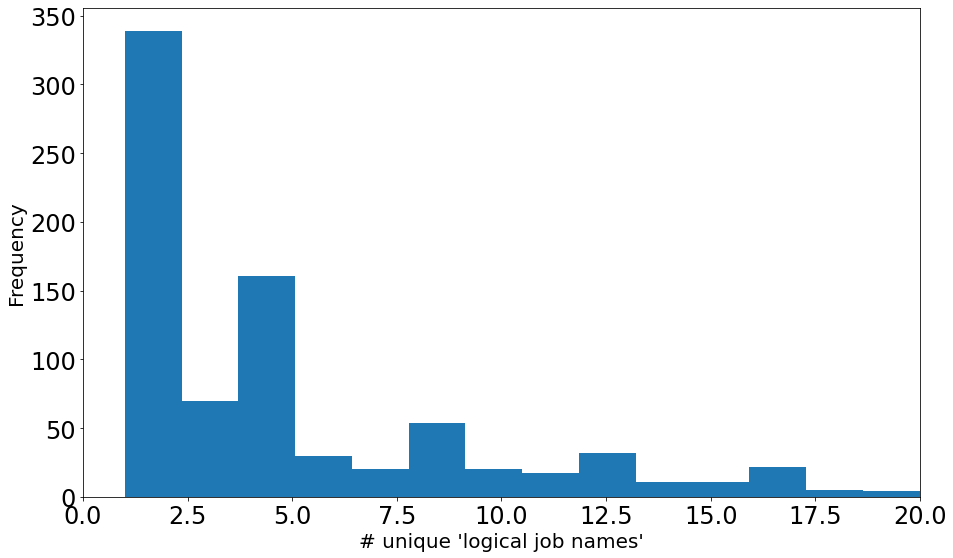

In [8]:
plt.figure(figsize=(15,9))
users_stats.plot.hist(bins=10000)
plt.xlim((0, 20))
plt.xlabel("# unique 'logical job names'", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

Now, looking at the users that deploy just one application, check how many times they run that application.

In [9]:
filtered_users = users_stats[users_stats == 1].index.values

In [10]:
users_stats_job_IDs = readings_job_events_df[readings_job_events_df["user"].isin(filtered_users)].groupby("user")["job ID"].nunique().compute()

users_stats_job_IDs.sort_values(ascending=False).head(20)

user
ycZRNU4RSQwgWWUZA4vMXg1cwARkHIDNw9cDpJ+TiVE=    818
V3gkaBYkRGmIYaZIQ/+HmwRJ6k42KIcrpigU8G0R1O8=    434
6EB7hF1fvEsKWCjZX4OFGYxJj3vcUmac79q4JBDMl/Q=     30
rOjLyD7YsdjJ8yK3pQuJypHImZTADsqJ+3gjrzCbhRs=     30
pro671Zu7PulbKcOxKwqh1mRzwj64eCx75vCeuTTNGs=     29
AWf+PDTvJuCNrv0g7ExfkXhvg0SmRIqErixnMQmsEdQ=     28
ZhZslXdLyGltlm84DrqTZje7GjDUGdVqnRLqaT9b5Ds=     28
RN8cn+u/XUphWe00LJyZAft6TBMVHDBtjDb6mxmcefw=     22
naRd74/Yj3/s9mrCvs9r1zrFhjbdkAvUo6AGA9HyyMs=     21
90P5pnzFfhJeTbcIDOA3aw3CPdc2CimYMNcpYJE+VCo=     20
qMqLkvDMbGclodo++PazSwJ/m1OBj1LR8ENI9ss+sIw=     19
Gwa0aFOSuaLGi77/ygwnuRA3q+ZEozcW+filXQEZk08=     13
Xpl0NK+SIprze/zxIFQ1da/IYvl8sWNrSC7UNFfpLBo=     11
9CBQ7SoN2Ugs70K7D0gNcDN4ontRHoh8xBki+oLCpvA=     10
BNk+QyW+yTXp2PRvCzIYviHHb2NmRBOmNKAIzTM8Eu8=     10
1axPeTXGqdyhBhp4kATcI3SXmglvL0k9ucaASoCgYVs=      9
ZNALrMu8fodKUX6AaIez0ktpGZ3T60bcX6QkOK1zeDg=      9
aduf8ZoM9pB9KVxjkmi7eYdWB7IJP2hn7NZAIEaKVUI=      8
yG6hka9ZjaGR86mL6V7tqhEogFsNhYU5/6w9rcTiQP0=      8
mda1j51

Now, on these users, plot the frequency of users that run the application 1 to 30 times.

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 0 Axes>

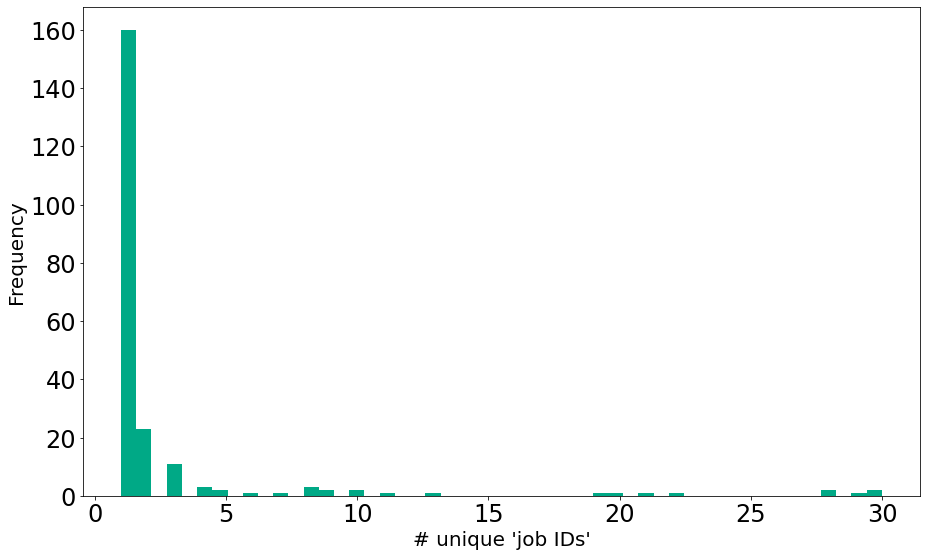

In [11]:
color = "#00a986"

plt.clf()
plt.figure(figsize=(15,9))
users_stats_job_IDs[users_stats_job_IDs <= 30].plot.hist(bins=50, color=color)
#plt.xlim((0, 20))
plt.xlabel("# unique 'job IDs'", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

### Select a user

Select user according to the max number of logical job names

In [12]:
selected_user_top = users_stats.sort_values(ascending=False).index.values[19]

Select user according to the number of Job IDs generated, given that he has a unique *logical job name*, excluding the ones that run more than 30 times.

In [13]:
selected_user = users_stats_job_IDs[users_stats_job_IDs <= 30].sort_values(ascending=False).index.values[0]
selected_user

'6EB7hF1fvEsKWCjZX4OFGYxJj3vcUmac79q4JBDMl/Q='

## Select jobs - single application user

Select the job ID that has the latest *submission time* - i.e., that has been submitted later than the others.

In [14]:
jobs_submit_time = readings_job_events_df[(readings_job_events_df["user"] == selected_user) & 
                                          (readings_job_events_df["event type"] == 0)][["job ID", "time"]].compute()

jobs_submit_time.sort_values(by=['time']).tail(3)

,job ID,time
3727,6455247290,2163246499342
1029,6455637114,2166492257319
1124,6459863349,2211803636806


Now, do the same analysis, with the *scheduling time*, i.e., when it has been scheduled

In [15]:
jobs_sched_time = readings_job_events_df[(readings_job_events_df["user"] == selected_user) & 
                                         (readings_job_events_df["event type"] == 1)][["job ID", "time"]].compute()

jobs_sched_time.sort_values(by=['time']).tail(3)


,job ID,time
3728,6455247290,2163248112413
1030,6455637114,2166493600612
1125,6459863349,2211805139889


Check that there is no more than one schedule for job ID.

In [16]:
jobs_sched_time.groupby("job ID")["time"].nunique().sort_values(ascending=False)

job ID
6274284294    1
6276205069    1
6455637114    1
6455247290    1
6455063115    1
6454994228    1
6371991663    1
6371293677    1
6370962787    1
6342533694    1
6342379496    1
6333973964    1
6331313842    1
6321052789    1
6320907352    1
6320272298    1
6318433294    1
6318360948    1
6295771211    1
6289351010    1
6288671063    1
6287530222    1
6286986566    1
6282477251    1
6282137911    1
6281608173    1
6280938625    1
6280098414    1
6279149566    1
6459863349    1
Name: time, dtype: int64

Select the last job, and print it out.

In [17]:
selected_job = jobs_sched_time.sort_values(by=['time'])["job ID"].values[-1]
selected_job

6459863349

## Extract tasks infos

Given the selected job, from the selected user, look into tasks, i.e., the executing characteristics of the job.

Extract the *task_usage* collection.

In [18]:
readings_task_usage_df = extract_delayed_dask_dataframe(data_path, df_schema, gcd_collection_name="task_usage", 
                                                        interval_start=0, interval_end=500)

Extract the *task_events* collection.

In [19]:
readings_task_events_df = extract_delayed_dask_dataframe(data_path, df_schema, gcd_collection_name="task_events", 
                                                        interval_start=0, interval_end=500)

Extract the most relevant features from the selected job

In [20]:
selected_job_requests = readings_task_events_df[readings_task_events_df['job ID'] == selected_job].groupby(["job ID", "CPU request", "memory request", 
                                                                                                            "disk space request"]).count().compute()

selected_job_requests.reset_index(inplace=True)

selected_job_requests = selected_job_requests[["job ID", "CPU request", "memory request", "disk space request", 
                                               'priority', 'different machines restriction']]

selected_job_requests

,job ID,CPU request,memory request,disk space request,priority,different machines restriction
0,6459863349,0.1875,0.04773,0.000019,3,3


Extract mean values

In [21]:
selected_job_requests_mean = readings_task_events_df[readings_task_events_df['job ID'] == selected_job].groupby(["job ID", "CPU request", "memory request",
                                                                                                                 "disk space request"]).mean().compute()

selected_job_requests_mean

,,,,time,missing info,task index,machine ID,event type,scheduling class,priority,different machines restriction
job ID,CPU request,memory request,disk space request,,,,,,,,
6459863349,0.1875,0.04773,0.000019,2.212289e+12,NaN,0.0,1272487.0,2.0,0.0,1.0,0.0


Extract statistics from the selected job, grouping by the end time.

In [22]:
selected_job_stats = readings_task_usage_df[readings_task_usage_df['job ID'] == selected_job].groupby("end time")[['start time', 'end time', 
                                                                                                                   'CPU rate', 'canonical memory usage', 'local disk space usage', 
                                                                                                                  ]].agg([
'mean',
'min',
'max',
dd.Aggregation("perc_15", chunk=lambda x: x.quantile(0.15), agg=lambda y: y.mean()),
dd.Aggregation("perc_25", chunk=lambda x: x.quantile(0.25), agg=lambda y: y.mean()),
dd.Aggregation("median",chunk=lambda x: x.quantile(0.50), agg=lambda y: y.mean()),
dd.Aggregation("perc_75", chunk=lambda x: x.quantile(0.15), agg=lambda y: y.mean()),
dd.Aggregation("perc_90", chunk=lambda x: x.quantile(0.90), agg=lambda y: y.mean()),
dd.Aggregation("perc_95", chunk=lambda x: x.quantile(0.95), agg=lambda y: y.mean()),
dd.Aggregation("perc_99", chunk=lambda x: x.quantile(0.99), agg=lambda y: y.mean()),
]).compute()

In [23]:
out = (selected_job_stats["CPU rate"].values / selected_job_requests["CPU request"].values[0])
out = np.concatenate((out, (selected_job_stats["canonical memory usage"].values / selected_job_requests["memory request"].values[0])), axis=1)
out = np.concatenate((out, (selected_job_stats["local disk space usage"].values / selected_job_requests["disk space request"].values[0])), axis=1)

selected_norm_usage = pd.DataFrame(data=out)

In [24]:
columns=[(              'CPU ratio',    'mean'),
            (              'CPU ratio',     'min'),
            (              'CPU ratio',     'max'),
            (              'CPU ratio', 'perc_15'),
            (              'CPU ratio', 'perc_25'),
            (              'CPU ratio',  'median'),
            (              'CPU ratio', 'perc_75'),
            (              'CPU ratio', 'perc_90'),
            (              'CPU ratio', 'perc_95'),
            (              'CPU ratio', 'perc_99'),
            ('canonical memory ratio',    'mean'),
            ('canonical memory ratio',     'min'),
            ('canonical memory ratio',     'max'),
            ('canonical memory ratio', 'perc_15'),
            ('canonical memory ratio', 'perc_25'),
            ('canonical memory ratio',  'median'),
            ('canonical memory ratio', 'perc_75'),
            ('canonical memory ratio', 'perc_90'),
            ('canonical memory ratio', 'perc_95'),
            ('canonical memory ratio', 'perc_99'),
            ('local disk space ratio',    'mean'),
            ('local disk space ratio',     'min'),
            ('local disk space ratio',     'max'),
            ('local disk space ratio', 'perc_15'),
            ('local disk space ratio', 'perc_25'),
            ('local disk space ratio',  'median'),
            ('local disk space ratio', 'perc_75'),
            ('local disk space ratio', 'perc_90'),
            ('local disk space ratio', 'perc_95'),
            ('local disk space ratio', 'perc_99')]

selected_norm_usage.columns = pd.MultiIndex.from_tuples(columns)
selected_norm_usage

CPU ratio                                                              \
        mean       min       max   perc_15   perc_25    median   perc_75   
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.196640  0.196640  0.196640  0.196640  0.196640  0.196640  0.196640   
2   0.492853  0.492853  0.492853  0.492853  0.492853  0.492853  0.492853   
3   0.125653  0.125653  0.125653  0.125653  0.125653  0.125653  0.125653   
4   0.210933  0.210933  0.210933  0.210933  0.210933  0.210933  0.210933   
5   0.206400  0.206400  0.206400  0.206400  0.206400  0.206400  0.206400   
6   0.196640  0.196640  0.196640  0.196640  0.196640  0.196640  0.196640   
7   0.218400  0.218400  0.218400  0.218400  0.218400  0.218400  0.218400   
8   0.221333  0.221333  0.221333  0.221333  0.221333  0.221333  0.221333   
9   0.191733  0.191733  0.191733  0.191733  0.191733  0.191733  0.191733   
10  0.230773  0.230773  0.230773  0.230773  0.230773  0.230773  0.230773   
11  0.207040  0.207040  0.207040  0.207040  0.207040  0.207040  0.207040   
12  0.376320  0.376320  0.376320  0.376320  0.376320  0.376320  0.376320   
13  0.112640  0.112640  0.112640  0.112640  0.112640  0.112640  0.112640   
14  0.173493  0.173493  0.173493  0.173493  0.173493  0.173493  0.173493   
15  0.213227  0.213227  0.213227  0.213227  0.213227  0.213227  0.213227   
16  0.274080  0.274080  0.274080  0.274080  0.274080  0.274080  0.274080   
17  0.214187  0.214187  0.214187  0.214187  0.214187  0.214187  0.214187   
18  0.208320  0.208320  0.208320  0.208320  0.208320  0.208320  0.208320   
19  0.207360  0.207360  0.207360  0.207360  0.207360  0.207360  0.207360   
20  0.203467  0.203467  0.203467  0.203467  0.203467  0.203467  0.203467   
21  0.216480  0.216480  0.216480  0.216480  0.216480  0.216480  0.216480   
22  0.165547  0.165547  0.165547  0.165547  0.165547  0.165547  0.165547   
23  0.205387  0.205387  0.205387  0.205387  0.205387  0.205387  0.205387   
24  0.203467  0.203467  0.203467  0.203467  0.203467  0.203467  0.203467   
25  0.233707  0.233707  0.233707  0.233707  0.233707  0.233707  0.233707   
26  0.241867  0.241867  0.241867  0.241867  0.241867  0.241867  0.241867   
27  0.226240  0.226240  0.226240  0.226240  0.226240  0.226240  0.226240   
28  0.301440  0.301440  0.301440  0.301440  0.301440  0.301440  0.301440   
29  0.143413  0.143413  0.143413  0.143413  0.143413  0.143413  0.143413   
30  0.183573  0.183573  0.183573  0.183573  0.183573  0.183573  0.183573   
31  0.208320  0.208320  0.208320  0.208320  0.208320  0.208320  0.208320   
32  0.187200  0.187200  0.187200  0.187200  0.187200  0.187200  0.187200   
33  0.205067  0.205067  0.205067  0.205067  0.205067  0.205067  0.205067   
34  0.202453  0.202453  0.202453  0.202453  0.202453  0.202453  0.202453   
35  0.210613  0.210613  0.210613  0.210613  0.210613  0.210613  0.210613   
36  0.188480  0.188480  0.188480  0.188480  0.188480  0.188480  0.188480   
37  0.215147  0.215147  0.215147  0.215147  0.215147  0.215147  0.215147   
38  0.114560  0.114560  0.114560  0.114560  0.114560  0.114560  0.114560   
39  0.011803  0.011803  0.011803  0.011803  0.011803  0.011803  0.011803   
40  0.007632  0.007632  0.007632  0.007632  0.007632  0.007632  0.007632   
41  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
42  0.002411  0.002411  0.002411  0.002411  0.002411  0.002411  0.002411   
43  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                                  ... local disk space ratio            \
     perc_90   perc_95   perc_99  ...                   mean  min  max   
0   0.000000  0.000000  0.000000  ...                    0.0  0.0  0.0   
1   0.196640  0.196640  0.196640  ...                    0.0  0.0  0.0   
2   0.492853  0.492853  0.492853  ...                    0.0  0.0  0.0   
3   0.125653  0.125653  0.125653  ...                    0.0  0.0  0.0   
4   0.210933  0.210933  0.210933  ...                    0.0  

### Other jobs

In [25]:
other_jobs = jobs_sched_time.sort_values(by=['time'])["job ID"].values[:-1]

### Other jobs requests

In [26]:
other_jobs_requests = readings_task_events_df[readings_task_events_df['job ID'].isin(other_jobs)].groupby(["job ID", "CPU request", "memory request", "disk space request"]).count().compute()

In [27]:
other_jobs_requests.reset_index(inplace=True)
other_jobs_requests = other_jobs_requests[["job ID", "CPU request", "memory request", "disk space request", 'priority', 'different machines restriction']]
print(len(other_jobs_requests), len(other_jobs))

29 29


In [28]:
other_jobs_requests

,job ID,CPU request,memory request,disk space request,priority,different machines restriction
0,6274284294,0.1250,0.02386,0.000019,6,6
1,6276205069,0.1250,0.02386,0.000019,3,3
2,6279149566,0.1250,0.02386,0.000019,3,3
3,6280098414,0.1250,0.02386,0.000019,36,36
4,6280938625,0.1250,0.02386,0.000019,42,42
5,6281608173,0.1875,0.02386,0.000019,51,51
6,6282137911,0.1875,0.02386,0.000019,42,42
7,6282477251,0.1875,0.02386,0.000019,75,75
8,6286986566,0.1875,0.02386,0.000019,42,42
9,6287530222,0.1875,0.04773,0.000019,48,48


In [29]:
other_jobs_requests_mean = readings_task_events_df[readings_task_events_df['job ID'].isin(other_jobs)].groupby(["job ID"]).mean().compute()

In [30]:
other_jobs_requests_mean

,time,missing info,task index,machine ID,event type,scheduling class,priority,CPU request,memory request,disk space request,different machines restriction
job ID,,,,,,,,,,,
6274284294,1.802082e+11,NaN,0.000000,3.196084e+09,1.166667,0.0,1.0,0.1250,0.02386,0.000019,0.0
6276205069,2.063551e+11,NaN,0.000000,3.869895e+07,2.000000,0.0,1.0,0.1250,0.02386,0.000019,0.0
6279149566,2.263826e+11,NaN,0.000000,8.580434e+08,2.000000,0.0,1.0,0.1250,0.02386,0.000019,0.0
6280098414,2.454064e+11,NaN,5.500000,4.177146e+08,2.000000,0.0,1.0,0.1250,0.02386,0.000019,0.0
6280938625,2.539758e+11,NaN,4.785714,5.615540e+08,1.809524,0.0,1.0,0.1250,0.02386,0.000019,0.0
6281608173,2.587604e+11,NaN,4.764706,8.940044e+08,1.666667,0.0,1.0,0.1875,0.02386,0.000019,0.0
6282137911,2.612880e+11,NaN,5.357143,2.567999e+09,1.857143,0.0,1.0,0.1875,0.02386,0.000019,0.0
6282477251,2.752439e+11,NaN,6.920000,1.673285e+09,1.533333,0.0,1.0,0.1875,0.02386,0.000019,0.0
6286986566,3.141835e+11,NaN,6.500000,1.776904e+09,1.952381,0.0,1.0,0.1875,0.02386,0.000019,0.0


### Other jobs stats

In [31]:
other_jobs_stats = readings_task_usage_df[readings_task_usage_df['job ID'].isin(other_jobs)].groupby(["job ID", "end time"])[['start time', 'end time', 
                                                                                                                              'CPU rate', 'canonical memory usage', 'local disk space usage',
                                                                                                                             ]].agg([
'mean',
'min',
'max',
dd.Aggregation("perc_15", chunk=lambda x: x.quantile(0.15), agg=lambda y: y.mean()),
dd.Aggregation("perc_25", chunk=lambda x: x.quantile(0.25), agg=lambda y: y.mean()),
dd.Aggregation("median",chunk=lambda x: x.quantile(0.50), agg=lambda y: y.mean()),
dd.Aggregation("perc_75", chunk=lambda x: x.quantile(0.15), agg=lambda y: y.mean()),
dd.Aggregation("perc_90", chunk=lambda x: x.quantile(0.90), agg=lambda y: y.mean()),
dd.Aggregation("perc_95", chunk=lambda x: x.quantile(0.95), agg=lambda y: y.mean()),
dd.Aggregation("perc_99", chunk=lambda x: x.quantile(0.99), agg=lambda y: y.mean()),
]).compute()

other_jobs_stats.reset_index(inplace=True)

In [32]:
other_jobs_stats.mean()

job ID                             6.327996e+09
end time                           8.789120e+11
start time              mean       8.788428e+11
                        min        8.788397e+11
                        max        8.788478e+11
                        perc_15    8.788408e+11
                        perc_25    8.788415e+11
                        median     8.788428e+11
                        perc_75    8.788408e+11
                        perc_90    8.788451e+11
                        perc_95    8.788459e+11
                        perc_99    8.788471e+11
end time                mean       8.789120e+11
                        min        8.789120e+11
                        max        8.789120e+11
                        perc_15    8.789120e+11
                        perc_25    8.789120e+11
                        median     8.789120e+11
                        perc_75    8.789120e+11
                        perc_90    8.789120e+11
                        perc_95    8.789

In [33]:
length_workload_other_jobs = other_jobs_stats.groupby("job ID")[('start time', 'min'), ('end time', 'max')].agg(['min', 'max'])

In [34]:
length_workload_other_jobs['total'] = length_workload_other_jobs['end time']['max']['max'] - length_workload_other_jobs['start time']['min']['min']

In [35]:
length_workload_other_jobs_mins = length_workload_other_jobs['total'] / 1000000 / 60

In [36]:
length_workload_other_jobs_mins.describe()

count       29.000000
mean       908.154023
std       2770.052854
min          2.733333
25%         20.366667
50%         96.833333
75%        481.616667
max      14319.116667
Name: total, dtype: float64

In [37]:
for job in other_jobs_requests["job ID"].values:
    other_jobs_stats[other_jobs_stats["job ID"] == job]["CPU rate"] = other_jobs_stats[other_jobs_stats["job ID"] == job]["CPU rate"].values / other_jobs_requests[other_jobs_requests["job ID"] == job]["CPU request"].values[0]
    other_jobs_stats[other_jobs_stats["job ID"] == job]["canonical memory usage"] = other_jobs_stats[other_jobs_stats["job ID"] == job]["canonical memory usage"].values / other_jobs_requests[other_jobs_requests["job ID"] == job]["memory request"].values[0]
    other_jobs_stats[other_jobs_stats["job ID"] == job]["local disk space usage"] = other_jobs_stats[other_jobs_stats["job ID"] == job]["local disk space usage"].values / other_jobs_requests[other_jobs_requests["job ID"] == job]["disk space request"].values[0]


In [38]:
other_jobs_stats.mean()

job ID                             6.327996e+09
end time                           8.789120e+11
start time              mean       8.788428e+11
                        min        8.788397e+11
                        max        8.788478e+11
                        perc_15    8.788408e+11
                        perc_25    8.788415e+11
                        median     8.788428e+11
                        perc_75    8.788408e+11
                        perc_90    8.788451e+11
                        perc_95    8.788459e+11
                        perc_99    8.788471e+11
end time                mean       8.789120e+11
                        min        8.789120e+11
                        max        8.789120e+11
                        perc_15    8.789120e+11
                        perc_25    8.789120e+11
                        median     8.789120e+11
                        perc_75    8.789120e+11
                        perc_90    8.789120e+11
                        perc_95    8.789

In [39]:
columns_others = [("job ID",),
 ("end time",),
 ('start time', 'mean'),
 ('start time', 'min'),
 ('start time', 'max'),
 ('start time', 'perc_15'),
 ('start time', 'perc_25'),
 ('start time', 'median'),
 ('start time', 'perc_75'),
 ('start time', 'perc_90'),
 ('start time', 'perc_95'),
 ('start time', 'perc_99'),
 ('end time', 'mean'),
 ('end time', 'min'),
 ('end time', 'max'),
 ('end time', 'perc_15'),
 ('end time', 'perc_25'),
 ('end time', 'median'),
 ('end time', 'perc_75'),
 ('end time', 'perc_90'),
 ('end time', 'perc_95'),
 ('end time', 'perc_99'),
 ('CPU ratio', 'mean'),
 ('CPU ratio', 'min'),
 ('CPU ratio', 'max'),
 ('CPU ratio', 'perc_15'),
 ('CPU ratio', 'perc_25'),
 ('CPU ratio', 'median'),
 ('CPU ratio', 'perc_75'),
 ('CPU ratio', 'perc_90'),
 ('CPU ratio', 'perc_95'),
 ('CPU ratio', 'perc_99'),
 ('canonical memory ratio', 'mean'),
 ('canonical memory ratio', 'min'),
 ('canonical memory ratio', 'max'),
 ('canonical memory ratio', 'perc_15'),
 ('canonical memory ratio', 'perc_25'),
 ('canonical memory ratio', 'median'),
 ('canonical memory ratio', 'perc_75'),
 ('canonical memory ratio', 'perc_90'),
 ('canonical memory ratio', 'perc_95'),
 ('canonical memory ratio', 'perc_99'),
 ('local disk space ratio', 'mean'),
 ('local disk space ratio', 'min'),
 ('local disk space ratio', 'max'),
 ('local disk space ratio', 'perc_15'),
 ('local disk space ratio', 'perc_25'),
 ('local disk space ratio', 'median'),
 ('local disk space ratio', 'perc_75'),
 ('local disk space ratio', 'perc_90'),
 ('local disk space ratio', 'perc_95'),
 ('local disk space ratio', 'perc_99')]

In [40]:
other_jobs_stats.columns = pd.MultiIndex.from_tuples(columns_others)

## Comparison plots

Here, we plot the results and statistics obtained from the selected job and the other jobs, in term of CPU usage, and memory usage, over the requested amount for the resources.

<Figure size 432x288 with 0 Axes>

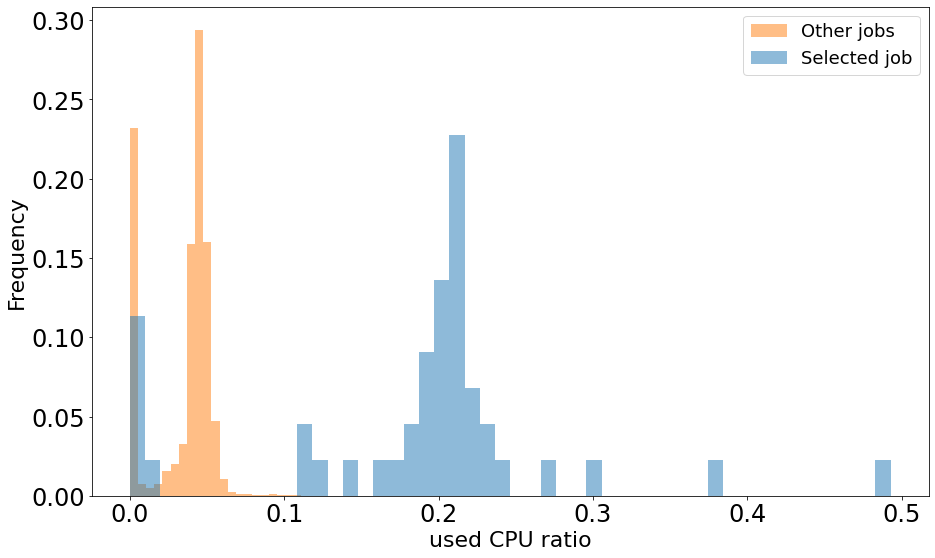

In [41]:
extract_jobs_comparison_plot(selected_norm_usage, other_jobs_stats, "CPU ratio")

<Figure size 432x288 with 0 Axes>

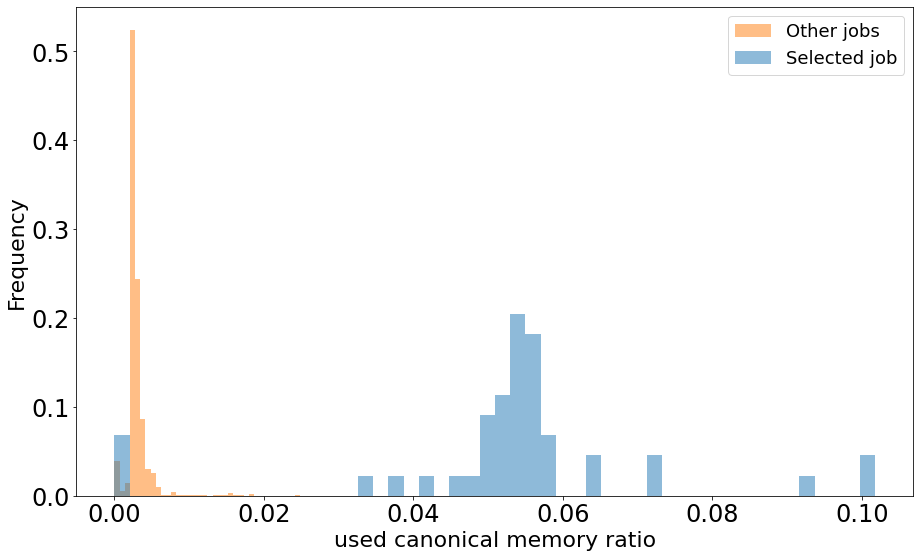

In [42]:
extract_jobs_comparison_plot(selected_norm_usage, other_jobs_stats, "canonical memory ratio")

## Watermark

In [43]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2022-01-24T08:55:33.462301+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.18.0-193.28.1.el8_2.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 80
Architecture: 64bit

matplotlib: 3.4.3
pandas    : 1.3.5
numpy     : 1.21.2
dask      : 2021.10.0

